# Video Deepfake Detection 

## Imports

In [2]:
import cv2
import os
from pathlib import Path
import numpy as np
import os
import tensorflow as tf
import statistics
import matplotlib.pyplot as plt
import math
from tensorflow.keras.preprocessing import image
import random
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense , Flatten , MaxPooling2D
from tensorflow.keras.applications import VGG16 , ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout
import gc
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.model_selection import KFold , StratifiedKFold
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
from keras.callbacks import ModelCheckpoint
import seaborn as sns
from sklearn.metrics import classification_report

## Check GPU 

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(gpu.name)
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No gpu devices found")

/physical_device:GPU:0
/physical_device:GPU:1


## Utility Functions

In [4]:
def plot_metrics(all_histories, metric_names, figsize=(12, 4)):
    num_metrics = len(metric_names)

    f, axes = plt.subplots(1, num_metrics, figsize=figsize)
    f.subplots_adjust(top=0.85, wspace=0.3)

    for metric_index, metric_name in enumerate(metric_names):
        ax = axes[metric_index]
        for fold_index, history in enumerate(all_histories):
            epoch_list =  [1 , 2 , 3 , 4 , 5,6,7,8,9,10,11,12,13,14,15]

            ax.plot(epoch_list, history[metric_name], label=f'Split {fold_index + 1} {metric_name.capitalize()}')

        ax.set_xticks([1 , 2 , 3 , 4 , 5,6,7,8,9,10,11,12,13,14,15])
        ax.set_ylabel(f'{metric_name.capitalize()} Value')
        ax.set_xlabel('Epoch #')
        ax.set_title(metric_name.capitalize())
        ax.legend(loc="best")

    plt.tight_layout()

    # Show the plot
    plt.show()

In [5]:
def plot_confusion_matrix(y_true, y_pred , labels):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

## Custom Data Generator 

In [6]:
random.seed(42)
frames_per_video = 54 

class MyDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, dataframe, ids, batch_size, shuffle=True):
        
        self.df = []
        for df in dataframe:
            if df['Person_Label'][0] in ids: 
                self.df.append(df)

        self.batch_size = batch_size
        self.shuffle = shuffle

    
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y

    def __get_faces(self, path, x1, x2, y1, y2):
        frame = cv2.imread(path)
        cropped_face = frame[y1:y2, x1:x2]
        resized_frame = cv2.resize(cropped_face, (224, 224))
        #normalized_frame = resized_frame / 255.0
        return resized_frame 

    def __get_data(self, batches):
        
        X_batch_all = []
        y_batch_all = []
        
        for video in batches:
            video = video.head(frames_per_video)
            
            path_batch = video['Image_Path']
            label_batch = video['Label']
            x1_batch = video['x1']
            x2_batch = video['x2']
            y1_batch = video['y1']
            y2_batch = video['y2']

            X_batch = np.asarray([self.__get_faces(x, x1, x2, y1, y2) for x, x1, x2, y1, y2 in zip(path_batch, x1_batch, x2_batch, y1_batch, y2_batch)])
            y_batch = np.asarray(label_batch)
            X_batch_all.append(X_batch)
            y_batch_all.append(y_batch[0])

        X_batch_all = np.stack(X_batch_all, axis=0)
        y_batch_all =np.asarray(y_batch_all)
        
        return X_batch_all, y_batch_all

    def get_true_labels(self):
        labels = []
        
        for video in self.df:
            labels.append(video["Label"][0])
            
        return labels
    
    def on_epoch_end(self):

        if self.shuffle:
            random.shuffle(self.df)

## Read Dataframes 

In [7]:
low_path = "/kaggle/input/my-data-info/low"
real_path = "/kaggle/input/my-data-info/real"
high_path = "/kaggle/input/my-data-info/high"

def read_dataframes_from_directory(directory):
    dataframes = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"): 
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            dataframes.append(df)
    return dataframes

low_dataframes = read_dataframes_from_directory(low_path)
high_dataframes = read_dataframes_from_directory(high_path)
real_dataframes = read_dataframes_from_directory(real_path)

print(len(low_dataframes))
print(len(high_dataframes))

320
320


## Create Final LQ/Real List of Dataframes

In [8]:
shuffled_low_real = low_dataframes + real_dataframes
random.shuffle(shuffled_low_real)
print(len(shuffled_low_real))

640


In [9]:
lens = [] 
for i in range(len(low_dataframes)):
    lens.append(len(low_dataframes[i]))
lens = sorted(lens)
print(lens)
print(statistics.median(lens))
print(lens[159])
print(lens[160])

print(sum(lens))

[54, 57, 57, 58, 60, 60, 61, 62, 63, 63, 64, 65, 67, 67, 68, 69, 69, 70, 71, 71, 71, 71, 72, 72, 72, 72, 72, 73, 74, 74, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 77, 77, 77, 78, 78, 78, 78, 79, 79, 79, 80, 80, 80, 80, 81, 81, 81, 81, 81, 82, 82, 82, 82, 83, 83, 83, 83, 84, 84, 84, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 89, 89, 89, 89, 89, 90, 90, 90, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 93, 93, 93, 94, 94, 94, 94, 94, 94, 95, 95, 95, 95, 95, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 100, 100, 101, 101, 101, 101, 101, 101, 102, 102, 102, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 107, 107, 107, 108, 108, 108, 109, 109, 109, 109, 109, 109, 110, 110, 110, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 115, 115, 115, 115, 115, 115, 115, 115, 115, 116, 116, 116, 116, 117, 117, 11

In [10]:
lens = [] 
for i in range(len(high_dataframes)):
    lens.append(len(high_dataframes[i]))

lens = sorted(lens)
print(lens)
print(statistics.median(lens))
print(lens[159])
print(lens[160])

[54, 56, 56, 58, 60, 60, 61, 62, 63, 63, 64, 65, 67, 67, 68, 69, 69, 70, 71, 71, 71, 71, 72, 72, 72, 72, 72, 73, 74, 74, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 77, 77, 77, 78, 78, 78, 78, 79, 79, 79, 80, 80, 80, 80, 81, 81, 81, 81, 81, 82, 82, 82, 82, 83, 83, 83, 83, 84, 84, 84, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 89, 89, 89, 89, 89, 90, 90, 90, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 93, 93, 93, 94, 94, 94, 94, 94, 94, 95, 95, 95, 95, 95, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 100, 100, 101, 101, 101, 101, 101, 101, 102, 102, 102, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 107, 107, 107, 108, 108, 108, 109, 109, 109, 109, 109, 109, 110, 110, 110, 111, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 114, 114, 114, 115, 115, 115, 115, 115, 115, 116, 116, 116, 116, 117, 117, 11

## Delete Bad Frames of HQ Dataset

In [11]:
new = [df[df['y1'] != -1] for df in high_dataframes]

In [12]:
lens = [] 
for i in range(len(new)):
    lens.append(len(new[i]))

lens = sorted(lens)
print(lens)

import statistics

print(statistics.median(lens))
print(lens[159])
print(lens[160])

print(sum(lens))

[54, 57, 57, 58, 60, 60, 61, 62, 63, 63, 64, 65, 67, 67, 68, 69, 69, 70, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 74, 74, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 78, 78, 78, 79, 79, 80, 80, 80, 80, 80, 80, 80, 81, 81, 81, 82, 82, 82, 83, 83, 83, 83, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 89, 89, 89, 90, 90, 90, 90, 91, 91, 91, 92, 92, 92, 92, 92, 92, 93, 93, 93, 94, 94, 94, 94, 94, 94, 95, 95, 95, 95, 95, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 101, 101, 101, 101, 102, 102, 102, 102, 103, 103, 103, 103, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 107, 107, 107, 108, 108, 108, 109, 109, 109, 109, 109, 110, 110, 110, 111, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 115, 115, 115, 115, 115, 115, 115, 115, 115, 116, 116, 116, 116, 117, 117, 11

## Create Final HQ/Real List of Dataframes

In [13]:
shuffled_high_real = new + real_dataframes
random.shuffle(shuffled_high_real)
print(len(shuffled_high_real))

640


# Resnet50 Freeze

In [9]:
def create_model(input_shape_frame , frames_per_video):
        
    max_frame = frames_per_video
    input_layer = Input(shape=(max_frame,) + input_shape_frame)
    
    
    vgg = ResNet50(weights='imagenet', include_top=True, input_shape=input_shape_frame)
    for layer in vgg.layers:
        layer.trainable = False 
    
    time_distributed_vgg = TimeDistributed(vgg)(input_layer)
    #-----------------
    lstm_layer_1 = LSTM(256, return_sequences = True)(time_distributed_vgg)
    lstm_layer_2  = LSTM(256)(lstm_layer_1)
    #-----------------

    output_layer = Dense(1, activation='sigmoid')(lstm_layer_2)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy' ,Precision() , Recall() , AUC()])
    
    return model 

## Train with LQ Data

In [10]:
num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Epochs = 15
batch_size = 4
epoch_list = list(range(1, Epochs + 1))
all_histories = []
result_train = []
result_test = []
all_y_true = []
all_y_pred_binary = []

#these two variables are used for kfold on persons. 
persons = np.arange(64)
labels = np.concatenate((np.ones(32), np.zeros(32)))


for fold_index, (train_index_p, test_index_p) in enumerate(kf.split(persons , labels)):
    
    K.clear_session()
    gc.collect()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_path = f"resnet_freeze_2_fold_54_{fold_index}.h5"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    model = create_model((224 , 224 , 3) , 54) 
    
    train_generator = MyDataGenerator(shuffled_low_real, train_index_p , batch_size)
    val_generator = MyDataGenerator(shuffled_low_real, test_index_p, batch_size )

    history = model.fit(train_generator, epochs=Epochs,validation_data=val_generator , callbacks = [checkpoint])

    all_histories.append(history.history)
    
    
    train_results = model.evaluate(train_generator)
    print("Metrics on train:")
    print(train_results)
    result_train.append(train_results)
        
    test_results = model.evaluate(val_generator)
    print("Metrics on test:")
    print(test_results)
    result_test.append(test_results)
    
    
    y_true =  val_generator.get_true_labels()
    y_pred = model.predict(val_generator)
    y_pred_binary = (y_pred > 0.5).astype(int) 
    all_y_pred_binary.append(y_pred_binary)
    all_y_true.append(y_true)

102967424/102967424 [==============================] - 3s 0us/step
Epoch 1/15
120/120 [==============================] - ETA: 0s - loss: 0.6352 - accuracy: 0.6458 - precision: 0.6683 - recall: 0.5792 - auc: 0.7278
Epoch 1: val_accuracy improved from -inf to 0.78750, saving model to resnet_freeze_2_fold_54_0.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 364s 3s/step - loss: 0.6352 - accuracy: 0.6458 - precision: 0.6683 - recall: 0.5792 - auc: 0.7278 - val_loss: 0.5156 - val_accuracy: 0.7875 - val_precision: 0.7347 - val_recall: 0.9000 - val_auc: 0.8420
Epoch 2/15
120/120 [==============================] - ETA: 0s - loss: 0.4371 - accuracy: 0.8042 - precision: 0.8017 - recall: 0.8083 - auc: 0.8803
Epoch 2: val_accuracy did not improve from 0.78750
120/120 [==============================] - 158s 1s/step - loss: 0.4371 - accuracy: 0.8042 - precision: 0.8017 - recall: 0.8083 - auc: 0.8803 - val_loss: 0.5715 - val_accuracy: 0.7063 - val_precision: 0.6435 - val_recall: 0.9250 - val_auc: 0.9014
Epoch 3/15
120/120 [==============================] - ETA: 0s - loss: 0.3417 - accuracy: 0.8708 - precision: 0.8504 - recall: 0.9000 - auc: 0.9261
Epoch 3: val_accuracy improved from 0.78750 to 0.83125, saving model to resnet_freeze_2_fold_54_0.h5
120/120 [==============================] - 159s 1s/step - loss

## Related Plots and Classification Report 

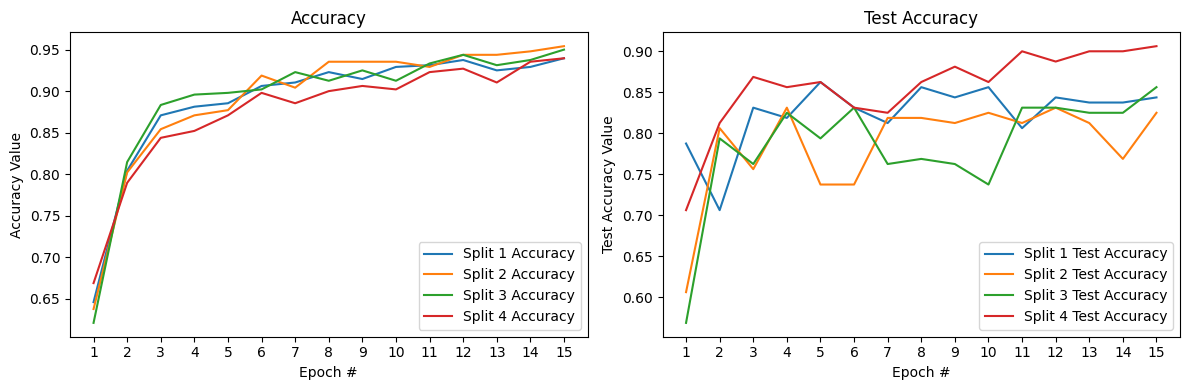

In [4]:
plot_metrics(all_histories, ["accuracy" , "val_accuracy"])

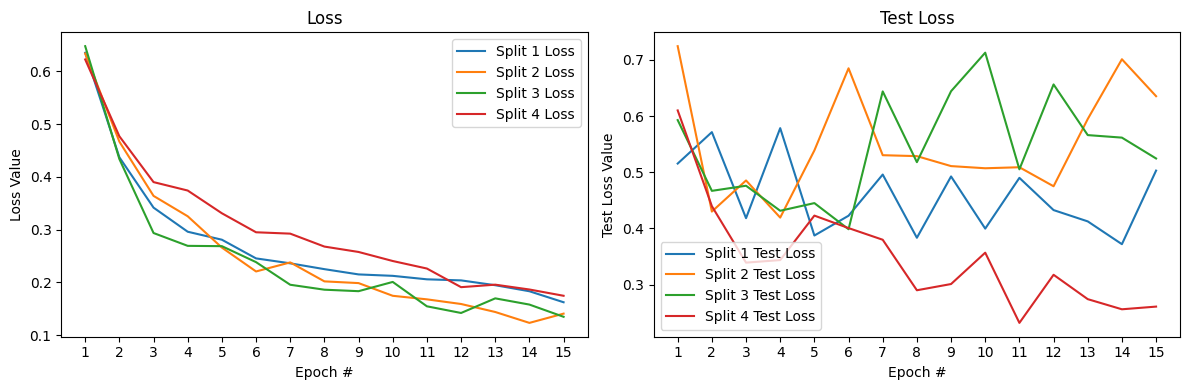

In [5]:
plot_metrics(all_histories, ["loss" , "val_loss"])

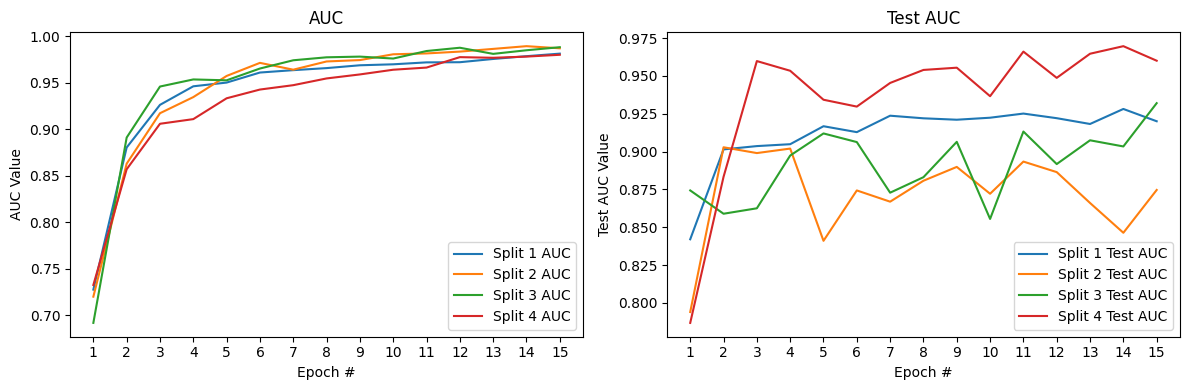

In [6]:
plot_metrics(all_histories, ["auc" , "val_auc"])

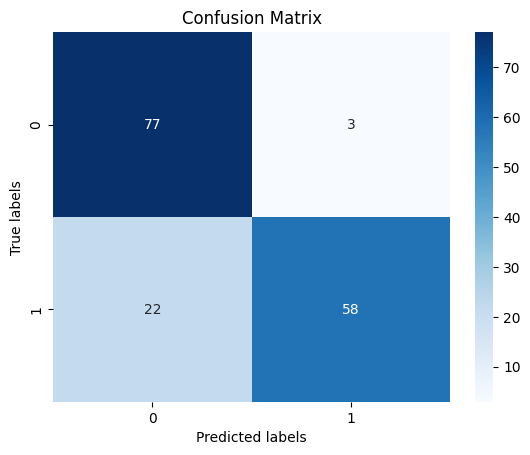

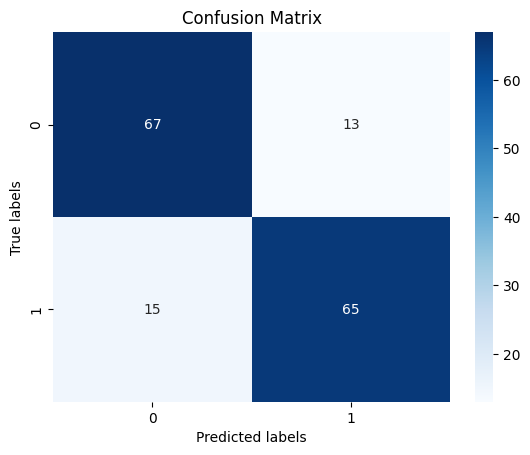

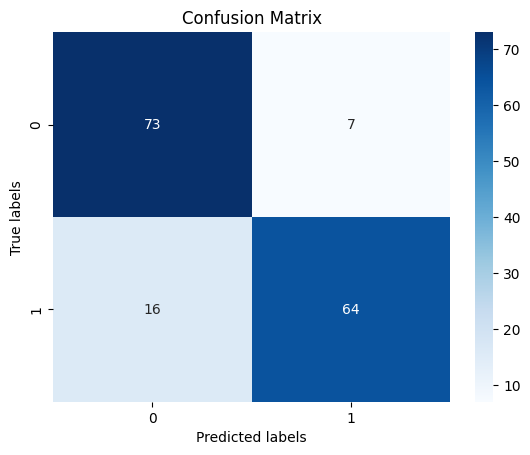

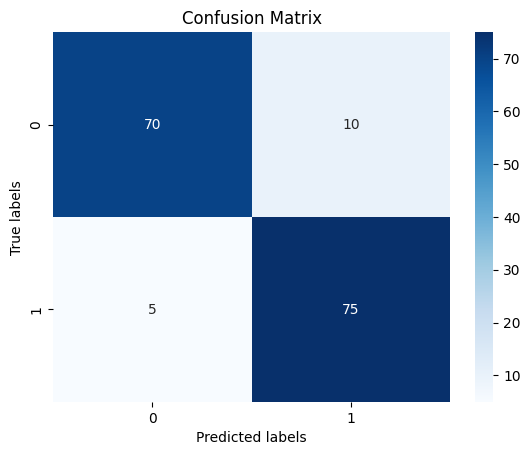

In [17]:
for i in range(len(all_histories)):
    plot_confusion_matrix(all_y_true[i], all_y_pred_binary[i] , [0 , 1])

In [18]:
for i in range(len(all_histories)):
    print(classification_report(all_y_true[i], all_y_pred_binary[i]))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86        80
           1       0.95      0.72      0.82        80

    accuracy                           0.84       160
   macro avg       0.86      0.84      0.84       160
weighted avg       0.86      0.84      0.84       160

              precision    recall  f1-score   support

           0       0.82      0.84      0.83        80
           1       0.83      0.81      0.82        80

    accuracy                           0.82       160
   macro avg       0.83      0.82      0.82       160
weighted avg       0.83      0.82      0.82       160

              precision    recall  f1-score   support

           0       0.82      0.91      0.86        80
           1       0.90      0.80      0.85        80

    accuracy                           0.86       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.86      0.86      0.86       160

              preci

## Train with HQ Data

In [15]:
num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Epochs = 15
batch_size = 4
epoch_list = list(range(1, Epochs + 1))
all_histories = []
result_train = []
result_test = []
all_y_true = []
all_y_pred_binary = []

#these two variables are used for kfold on persons. 
persons = np.arange(64)
labels = np.concatenate((np.ones(32), np.zeros(32)))


for fold_index, (train_index_p, test_index_p) in enumerate(kf.split(persons , labels)):
    
    K.clear_session()
    gc.collect()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_path = f"resnet_freeze_2_fold_54_{fold_index}.h5"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    model = create_model((224 , 224 , 3) , 54) 
    
    train_generator = MyDataGenerator(shuffled_low_real, train_index_p , batch_size)
    val_generator = MyDataGenerator(shuffled_low_real, test_index_p, batch_size )

    history = model.fit(train_generator, epochs=Epochs,validation_data=val_generator , callbacks = [checkpoint])

    all_histories.append(history.history)
    
    
    train_results = model.evaluate(train_generator)
    print("Metrics on train:")
    print(train_results)
    result_train.append(train_results)
        
    test_results = model.evaluate(val_generator)
    print("Metrics on test:")
    print(test_results)
    result_test.append(test_results)
    
    
    y_true =  val_generator.get_true_labels()
    y_pred = model.predict(val_generator)
    y_pred_binary = (y_pred > 0.5).astype(int) 
    all_y_pred_binary.append(y_pred_binary)
    all_y_true.append(y_true)

102967424/102967424 [==============================] - 1s 0us/step
Epoch 1/15
120/120 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.5583 - precision: 0.5470 - recall: 0.6792 - auc: 0.5528
Epoch 1: val_accuracy improved from -inf to 0.52500, saving model to resnet_freeze_2_fold_54_0.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 525s 4s/step - loss: 0.6897 - accuracy: 0.5583 - precision: 0.5470 - recall: 0.6792 - auc: 0.5528 - val_loss: 0.6841 - val_accuracy: 0.5250 - val_precision: 0.6250 - val_recall: 0.1250 - val_auc: 0.6422
Epoch 2/15
120/120 [==============================] - ETA: 0s - loss: 0.6083 - accuracy: 0.6792 - precision: 0.6886 - recall: 0.6542 - auc: 0.7319
Epoch 2: val_accuracy improved from 0.52500 to 0.57500, saving model to resnet_freeze_2_fold_54_0.h5
120/120 [==============================] - 204s 2s/step - loss: 0.6083 - accuracy: 0.6792 - precision: 0.6886 - recall: 0.6542 - auc: 0.7319 - val_loss: 0.8132 - val_accuracy: 0.5750 - val_precision: 0.5417 - val_recall: 0.9750 - val_auc: 0.6924
Epoch 3/15
120/120 [==============================] - ETA: 0s - loss: 0.5510 - accuracy: 0.7146 - precision: 0.6929 - recall: 0.7708 - auc: 0.7850
Epoch 3: val_accuracy improved from 0.57500 to 0.61875, saving model to resnet_freeze_2_fold_54_0.h5
120/120 [===

## Related Plots and Classification Report 

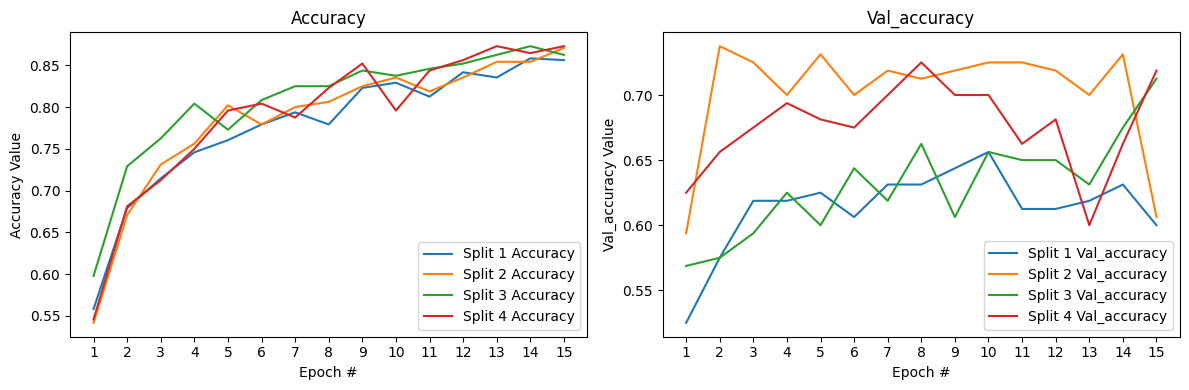

In [16]:
plot_metrics(all_histories, ["accuracy" , "val_accuracy"])

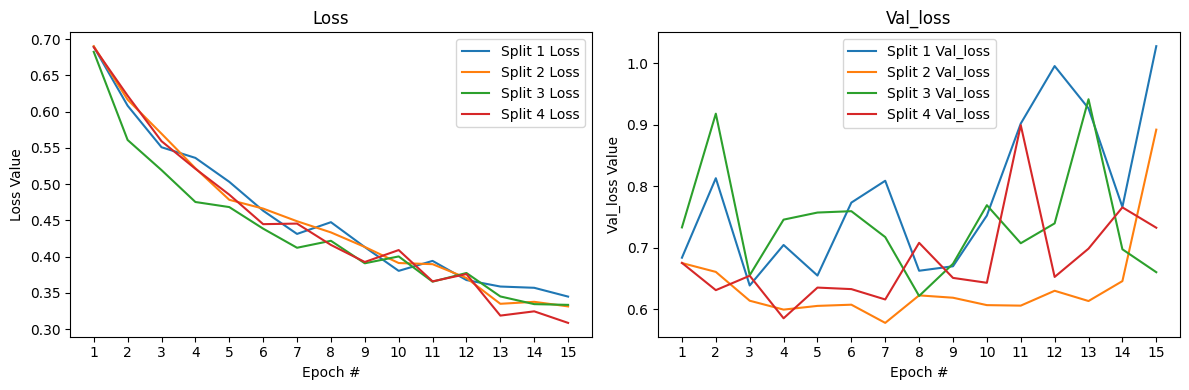

In [17]:
plot_metrics(all_histories, ["loss" , "val_loss"])

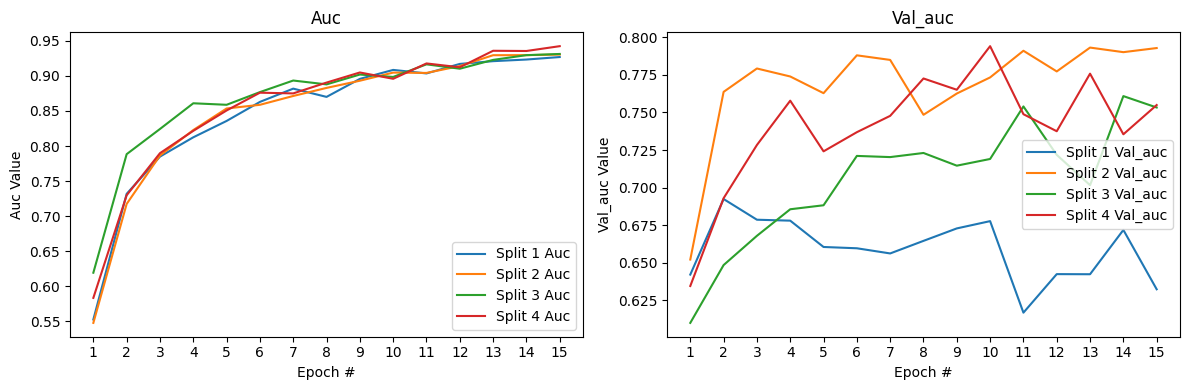

In [21]:
plot_metrics(all_histories, ["auc" , "val_auc"])

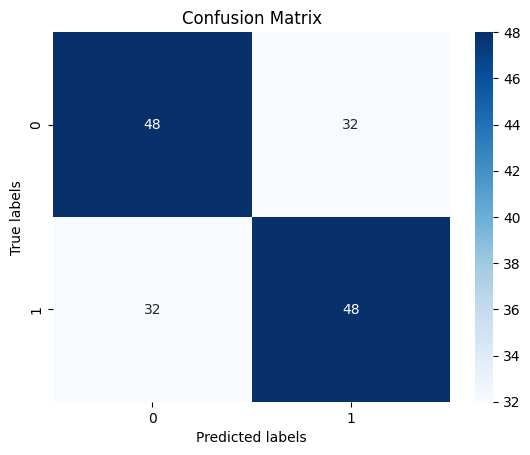

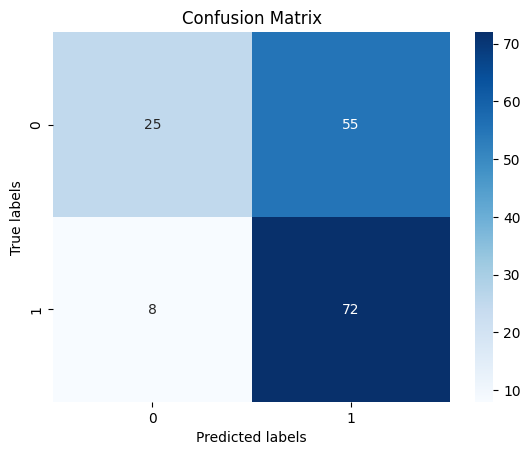

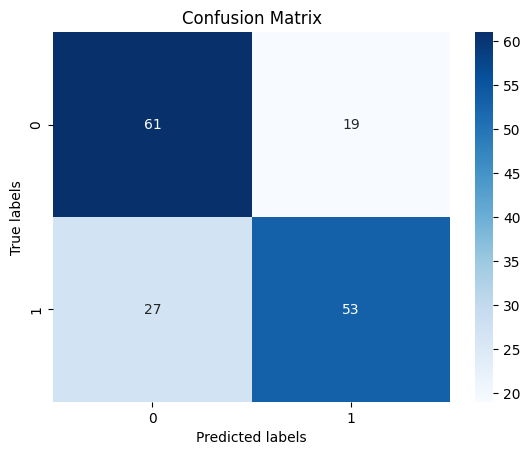

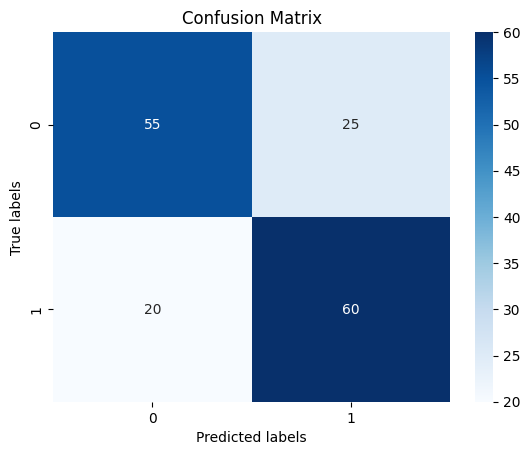

In [22]:
for i in range(len(all_histories)):
    plot_confusion_matrix(all_y_true[i], all_y_pred_binary[i] , [0 , 1])

In [23]:
for i in range(len(all_histories)):
    print(classification_report(all_y_true[i], all_y_pred_binary[i]))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        80
           1       0.60      0.60      0.60        80

    accuracy                           0.60       160
   macro avg       0.60      0.60      0.60       160
weighted avg       0.60      0.60      0.60       160

              precision    recall  f1-score   support

           0       0.76      0.31      0.44        80
           1       0.57      0.90      0.70        80

    accuracy                           0.61       160
   macro avg       0.66      0.61      0.57       160
weighted avg       0.66      0.61      0.57       160

              precision    recall  f1-score   support

           0       0.69      0.76      0.73        80
           1       0.74      0.66      0.70        80

    accuracy                           0.71       160
   macro avg       0.71      0.71      0.71       160
weighted avg       0.71      0.71      0.71       160

              preci

# Resnet50 Unfreeze Last Layer

In [13]:
def create_model(input_shape_frame , frames_per_video):
        
    max_frame = frames_per_video
    input_layer = Input(shape=(max_frame,) + input_shape_frame)
    
    
    vgg = ResNet50(weights='imagenet', include_top=True, input_shape=input_shape_frame)
    for layer in vgg.layers[:-1]:
        layer.trainable = False 
    
    time_distributed_vgg = TimeDistributed(vgg)(input_layer)

    #-----------------
    lstm_layer_1 = LSTM(256, return_sequences = True)(time_distributed_vgg)
    lstm_layer_2  = LSTM(256)(lstm_layer_1)
    #-----------------

    output_layer = Dense(1, activation='sigmoid')(lstm_layer_2)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy' ,Precision() , Recall() , AUC()])
    
    return model 

## Train with LQ Data

In [10]:
num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Epochs = 10
batch_size = 4
epoch_list = list(range(1, Epochs + 1))
all_histories = []
result_train = []
result_test = []
all_y_true = []
all_y_pred_binary = []

#these two variables are used for kfold on persons. 
persons = np.arange(64)
labels = np.concatenate((np.ones(32), np.zeros(32)))


for fold_index, (train_index_p, test_index_p) in enumerate(kf.split(persons , labels)):
    
    K.clear_session()
    gc.collect()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_path = f"resnet_freeze_2_fold_54_{fold_index}.h5"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    model = create_model((224 , 224 , 3) , 54) 
    
    train_generator = MyDataGenerator(shuffled_low_real, train_index_p , batch_size)
    val_generator = MyDataGenerator(shuffled_low_real, test_index_p, batch_size )

    history = model.fit(train_generator, epochs=Epochs,validation_data=val_generator , callbacks = [checkpoint])

    all_histories.append(history.history)
    
    
    train_results = model.evaluate(train_generator)
    print("Metrics on train:")
    print(train_results)
    result_train.append(train_results)
        
    test_results = model.evaluate(val_generator)
    print("Metrics on test:")
    print(test_results)
    result_test.append(test_results)
    
    
    y_true =  val_generator.get_true_labels()
    y_pred = model.predict(val_generator)
    y_pred_binary = (y_pred > 0.5).astype(int) 
    all_y_pred_binary.append(y_pred_binary)
    all_y_true.append(y_true)

102967424/102967424 [==============================] - 0s 0us/step
Epoch 1/10
120/120 [==============================] - ETA: 0s - loss: 0.5686 - accuracy: 0.7000 - precision: 0.7449 - recall: 0.6083 - auc: 0.7947
Epoch 1: val_accuracy improved from -inf to 0.82500, saving model to resnet_freeze_2_fold_54_0.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 581s 5s/step - loss: 0.5686 - accuracy: 0.7000 - precision: 0.7449 - recall: 0.6083 - auc: 0.7947 - val_loss: 0.4069 - val_accuracy: 0.8250 - val_precision: 0.7889 - val_recall: 0.8875 - val_auc: 0.9088
Epoch 2/10
120/120 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9354 - precision: 0.9300 - recall: 0.9417 - auc: 0.9735
Epoch 2: val_accuracy improved from 0.82500 to 0.86875, saving model to resnet_freeze_2_fold_54_0.h5
120/120 [==============================] - 204s 2s/step - loss: 0.1883 - accuracy: 0.9354 - precision: 0.9300 - recall: 0.9417 - auc: 0.9735 - val_loss: 0.3246 - val_accuracy: 0.8687 - val_precision: 0.8242 - val_recall: 0.9375 - val_auc: 0.9646
Epoch 3/10
120/120 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9667 - precision: 0.9628 - recall: 0.9708 - auc: 0.9905
Epoch 3: val_accuracy improved from 0.86875 to 0.92500, saving model to resnet_freeze_2_fold_54_0.h5
120/120 [===

## Related Plots and Classification Report 

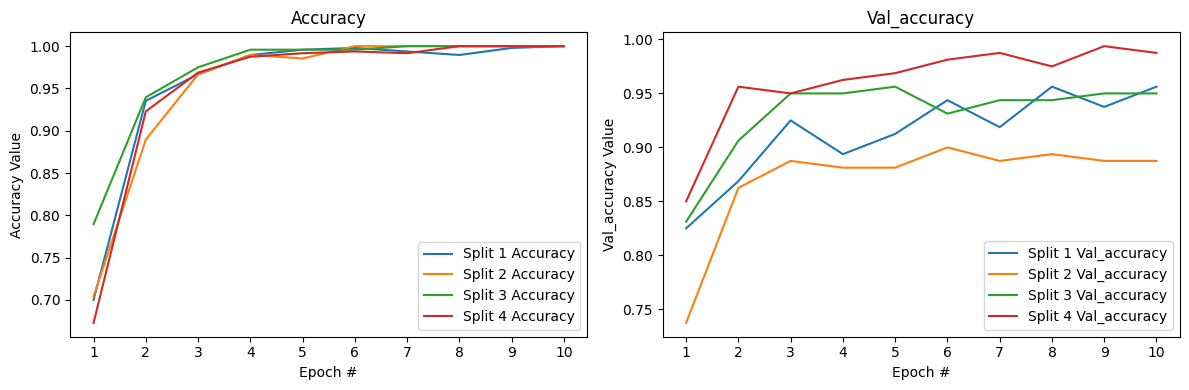

In [12]:
plot_metrics(all_histories, ["accuracy" , "val_accuracy"])

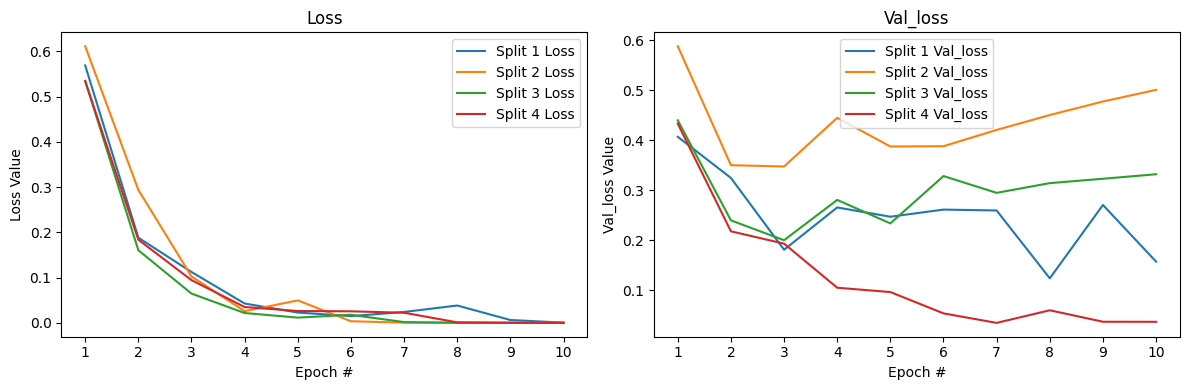

In [14]:
plot_metrics(all_histories, ["loss" , "val_loss"])

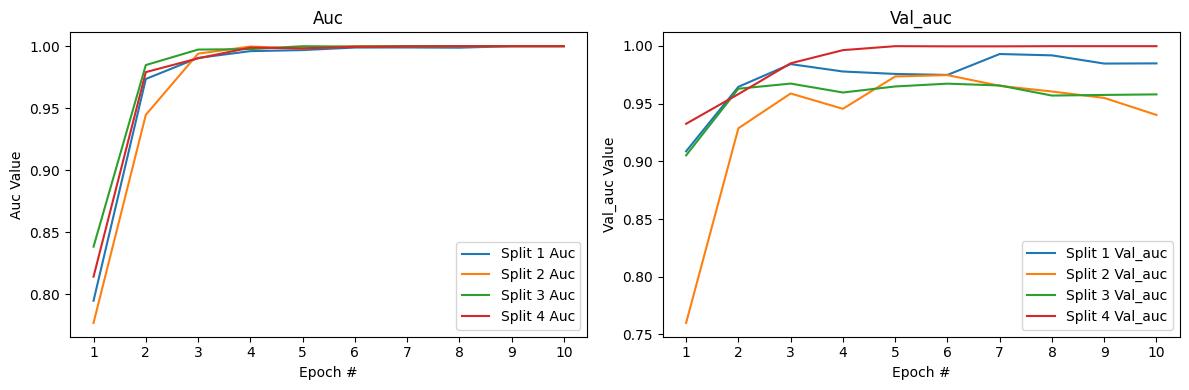

In [15]:
plot_metrics(all_histories, ["auc" , "val_auc"])

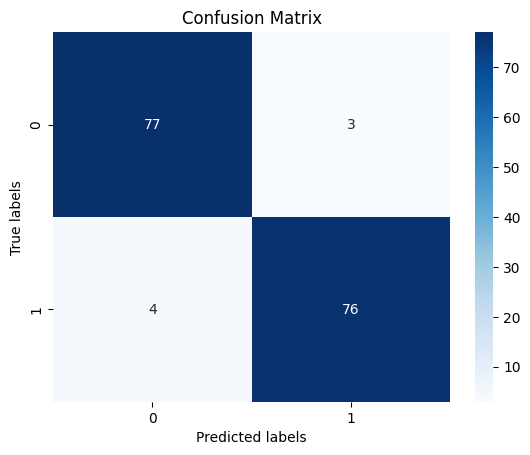

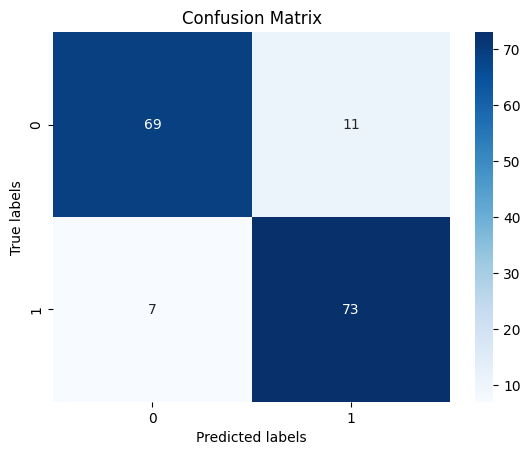

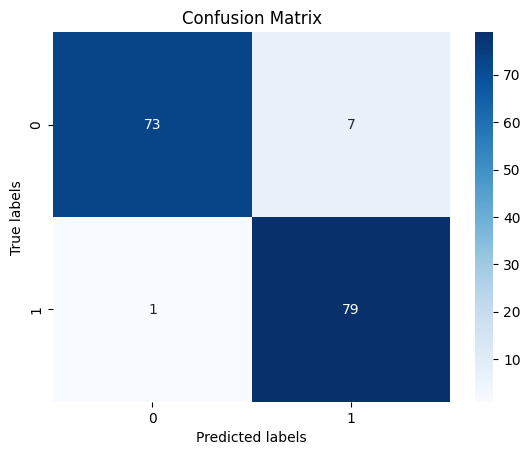

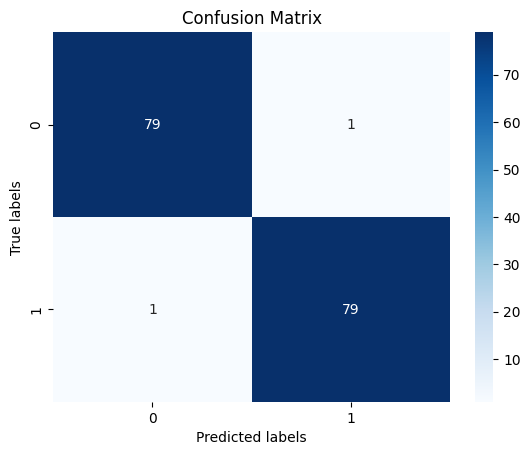

In [18]:
for i in range(len(all_histories)):
    plot_confusion_matrix(all_y_true[i], all_y_pred_binary[i] , [0 , 1])

In [19]:
for i in range(len(all_histories)):
    print(classification_report(all_y_true[i], all_y_pred_binary[i]))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96        80
           1       0.96      0.95      0.96        80

    accuracy                           0.96       160
   macro avg       0.96      0.96      0.96       160
weighted avg       0.96      0.96      0.96       160

              precision    recall  f1-score   support

           0       0.91      0.86      0.88        80
           1       0.87      0.91      0.89        80

    accuracy                           0.89       160
   macro avg       0.89      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160

              precision    recall  f1-score   support

           0       0.99      0.91      0.95        80
           1       0.92      0.99      0.95        80

    accuracy                           0.95       160
   macro avg       0.95      0.95      0.95       160
weighted avg       0.95      0.95      0.95       160

              preci

## Train with HQ Data

In [14]:
num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Epochs = 10
batch_size = 4
epoch_list = list(range(1, Epochs + 1))
all_histories = []
result_train = []
result_test = []
all_y_true = []
all_y_pred_binary = []

#these two variables are used for kfold on persons. 
persons = np.arange(64)
labels = np.concatenate((np.ones(32), np.zeros(32)))


for fold_index, (train_index_p, test_index_p) in enumerate(kf.split(persons , labels)):
    
    K.clear_session()
    gc.collect()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_path = f"resnet_unfreeze_2_fold_54_{fold_index}.h5"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    model = create_model((224 , 224 , 3) , 54) 
    
    train_generator = MyDataGenerator(shuffled_low_real, train_index_p , batch_size)
    val_generator = MyDataGenerator(shuffled_low_real, test_index_p, batch_size )

    history = model.fit(train_generator, epochs=Epochs,validation_data=val_generator , callbacks = [checkpoint])

    all_histories.append(history.history)
    
    
    train_results = model.evaluate(train_generator)
    print("Metrics on train:")
    print(train_results)
    result_train.append(train_results)
        
    test_results = model.evaluate(val_generator)
    print("Metrics on test:")
    print(test_results)
    result_test.append(test_results)
    
    
    y_true =  val_generator.get_true_labels()
    y_pred = model.predict(val_generator)
    y_pred_binary = (y_pred > 0.5).astype(int) 
    all_y_pred_binary.append(y_pred_binary)
    all_y_true.append(y_true)

102967424/102967424 [==============================] - 1s 0us/step
Epoch 1/10
120/120 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.6104 - precision: 0.5936 - recall: 0.7000 - auc: 0.6488
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to resnet_unfreeze_2_fold_54_0.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 377s 3s/step - loss: 0.6682 - accuracy: 0.6104 - precision: 0.5936 - recall: 0.7000 - auc: 0.6488 - val_loss: 0.6779 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000 - val_auc: 0.6091
Epoch 2/10
120/120 [==============================] - ETA: 0s - loss: 0.4466 - accuracy: 0.8000 - precision: 0.7927 - recall: 0.8125 - auc: 0.8822
Epoch 2: val_accuracy improved from 0.60000 to 0.61250, saving model to resnet_unfreeze_2_fold_54_0.h5
120/120 [==============================] - 158s 1s/step - loss: 0.4466 - accuracy: 0.8000 - precision: 0.7927 - recall: 0.8125 - auc: 0.8822 - val_loss: 0.8723 - val_accuracy: 0.6125 - val_precision: 0.5776 - val_recall: 0.8375 - val_auc: 0.6901
Epoch 3/10
120/120 [==============================] - ETA: 0s - loss: 0.2282 - accuracy: 0.9208 - precision: 0.9316 - recall: 0.9083 - auc: 0.9665
Epoch 3: val_accuracy improved from 0.61250 to 0.72500, saving model to resnet_unfreeze_2_fold_54_0.h5
120/120 

## Related Plots and Classification Report 

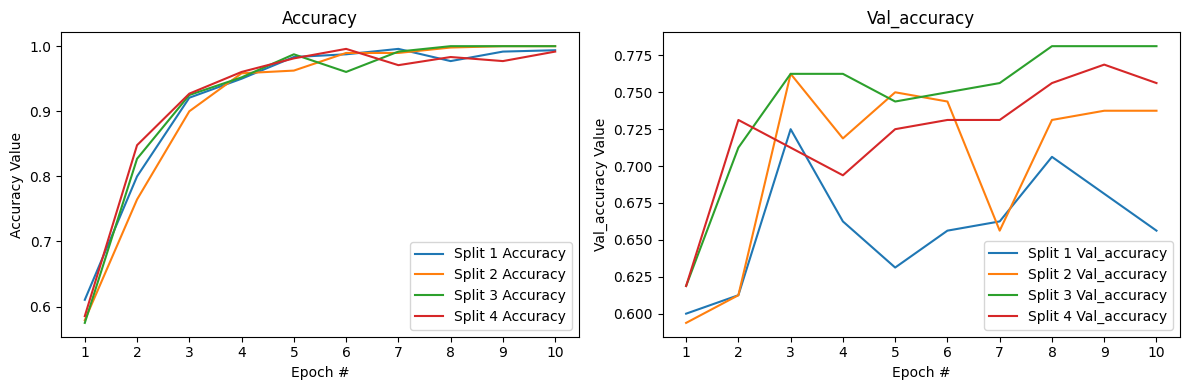

In [17]:
plot_metrics(all_histories, ["accuracy" , "val_accuracy"])

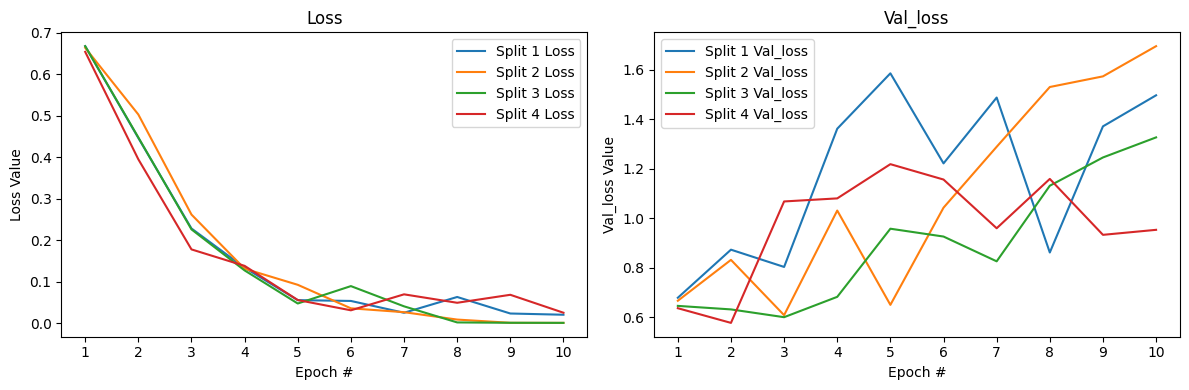

In [18]:
plot_metrics(all_histories, ["loss" , "val_loss"])

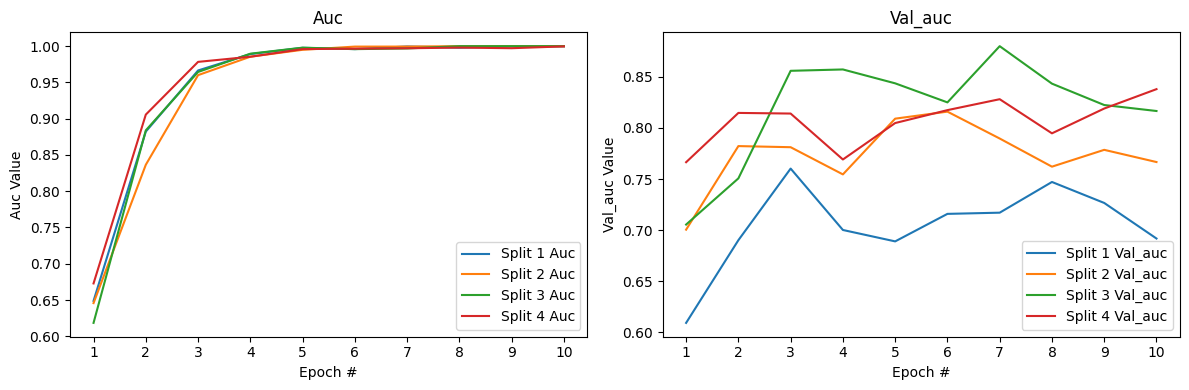

In [19]:
plot_metrics(all_histories, ["auc" , "val_auc"])

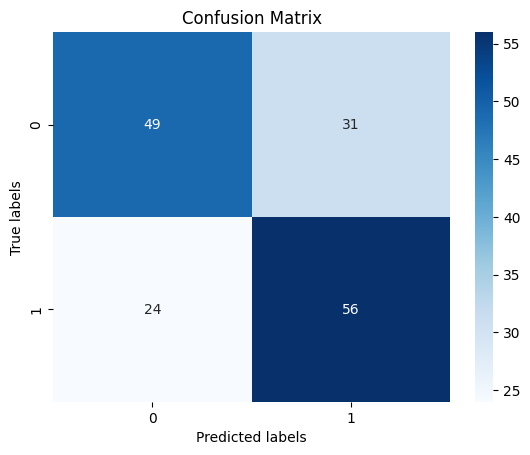

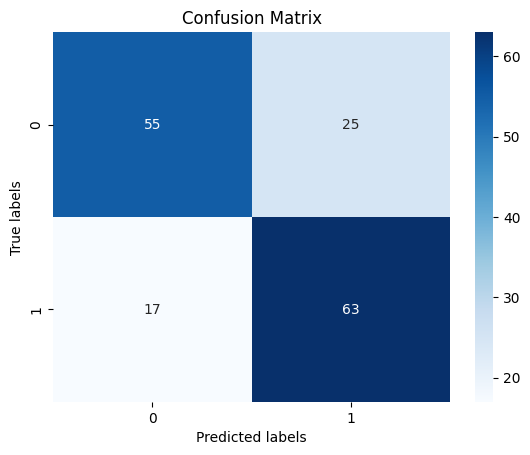

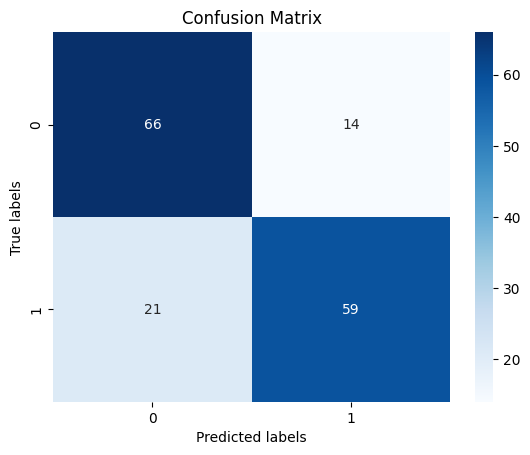

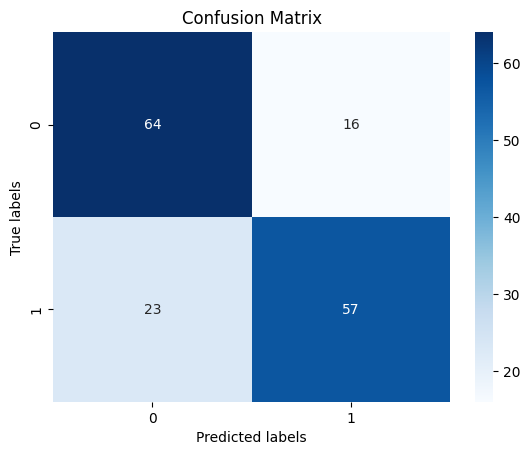

In [22]:
for i in range(len(all_histories)):
    plot_confusion_matrix(all_y_true[i], all_y_pred_binary[i] , [0 , 1])

In [23]:
for i in range(len(all_histories)):
    print(classification_report(all_y_true[i], all_y_pred_binary[i]))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64        80
           1       0.64      0.70      0.67        80

    accuracy                           0.66       160
   macro avg       0.66      0.66      0.66       160
weighted avg       0.66      0.66      0.66       160

              precision    recall  f1-score   support

           0       0.76      0.69      0.72        80
           1       0.72      0.79      0.75        80

    accuracy                           0.74       160
   macro avg       0.74      0.74      0.74       160
weighted avg       0.74      0.74      0.74       160

              precision    recall  f1-score   support

           0       0.76      0.82      0.79        80
           1       0.81      0.74      0.77        80

    accuracy                           0.78       160
   macro avg       0.78      0.78      0.78       160
weighted avg       0.78      0.78      0.78       160

              preci

# VGG16 Freeze 

In [11]:
def create_model(input_shape_frame , frames_per_video):
        
    max_frame = frames_per_video
    input_layer = Input(shape=(max_frame,) + input_shape_frame)
    
    
    vgg = VGG16(weights='imagenet', include_top=True, input_shape=input_shape_frame)
    for layer in vgg.layers:
        layer.trainable = False 
    
    time_distributed_vgg = TimeDistributed(vgg)(input_layer)
    
    #-----------------
    lstm_layer_1 = LSTM(256, return_sequences = True)(time_distributed_vgg)
    lstm_layer_2  = LSTM(256)(lstm_layer_1)
    #-----------------

    output_layer = Dense(1, activation='sigmoid')(lstm_layer_2)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy' ,Precision() , Recall() , AUC()])
    
    return model 

## Train with LQ Data

In [12]:
num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Epochs = 15
batch_size = 4
epoch_list = list(range(1, Epochs + 1))
all_histories = []
result_train = []
result_test = []
all_y_true = []
all_y_pred_binary = []

#these two variables are used for kfold on persons. 
persons = np.arange(64)
labels = np.concatenate((np.ones(32), np.zeros(32)))


for fold_index, (train_index_p, test_index_p) in enumerate(kf.split(persons , labels)):
    
    K.clear_session()
    gc.collect()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_path = f"vgg_freeze_2_fold_high_54_{fold_index}.h5"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    model = create_model((224 , 224 , 3) , 54) 
    
    train_generator = MyDataGenerator(shuffled_low_real, train_index_p , batch_size)
    val_generator = MyDataGenerator(shuffled_low_real, test_index_p, batch_size )

    history = model.fit(train_generator, epochs=Epochs,validation_data=val_generator , callbacks = [checkpoint])

    all_histories.append(history.history)
    
    
    train_results = model.evaluate(train_generator)
    print("Metrics on train:")
    print(train_results)
    result_train.append(train_results)
        
    test_results = model.evaluate(val_generator)
    print("Metrics on test:")
    print(test_results)
    result_test.append(test_results)
    
    
    y_true =  val_generator.get_true_labels()
    y_pred = model.predict(val_generator)
    y_pred_binary = (y_pred > 0.5).astype(int) 
    all_y_pred_binary.append(y_pred_binary)
    all_y_true.append(y_true)

553467096/553467096 [==============================] - 13s 0us/step
Epoch 1/15
120/120 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.7875 - precision: 0.8286 - recall: 0.7250 - auc: 0.8643
Epoch 1: val_accuracy improved from -inf to 0.80625, saving model to vgg_freeze_2_fold_high_54_0.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 462s 4s/step - loss: 0.5045 - accuracy: 0.7875 - precision: 0.8286 - recall: 0.7250 - auc: 0.8643 - val_loss: 0.5039 - val_accuracy: 0.8062 - val_precision: 0.9016 - val_recall: 0.6875 - val_auc: 0.8831
Epoch 2/15
120/120 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.8687 - precision: 0.9041 - recall: 0.8250 - auc: 0.9291
Epoch 2: val_accuracy improved from 0.80625 to 0.85000, saving model to vgg_freeze_2_fold_high_54_0.h5
120/120 [==============================] - 165s 1s/step - loss: 0.3342 - accuracy: 0.8687 - precision: 0.9041 - recall: 0.8250 - auc: 0.9291 - val_loss: 0.3294 - val_accuracy: 0.8500 - val_precision: 0.8889 - val_recall: 0.8000 - val_auc: 0.9261
Epoch 3/15
120/120 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.8875 - precision: 0.8941 - recall: 0.8792 - auc: 0.9504
Epoch 3: val_accuracy improved from 0.85000 to 0.91250, saving model to vgg_freeze_2_fold_high_54_0.h5
120/120 

## Related Plots and Classification Report 

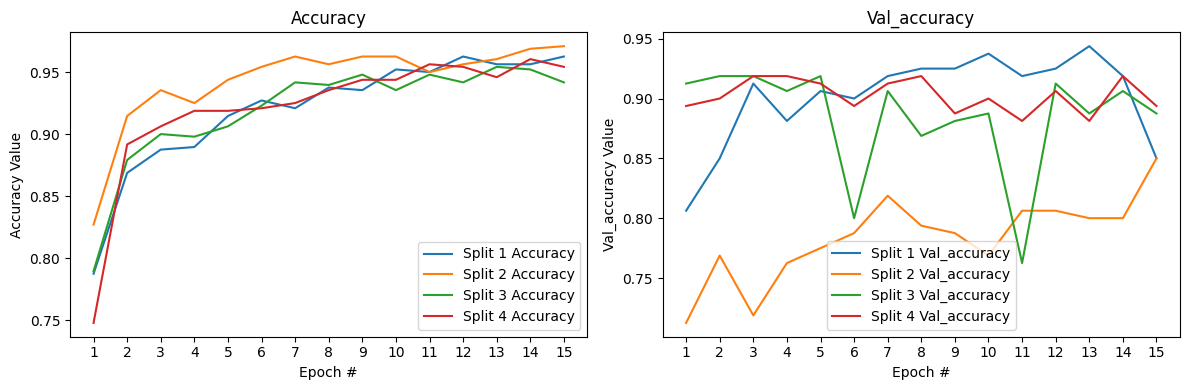

In [31]:
plot_metrics(all_histories, ["accuracy" , "val_accuracy"])

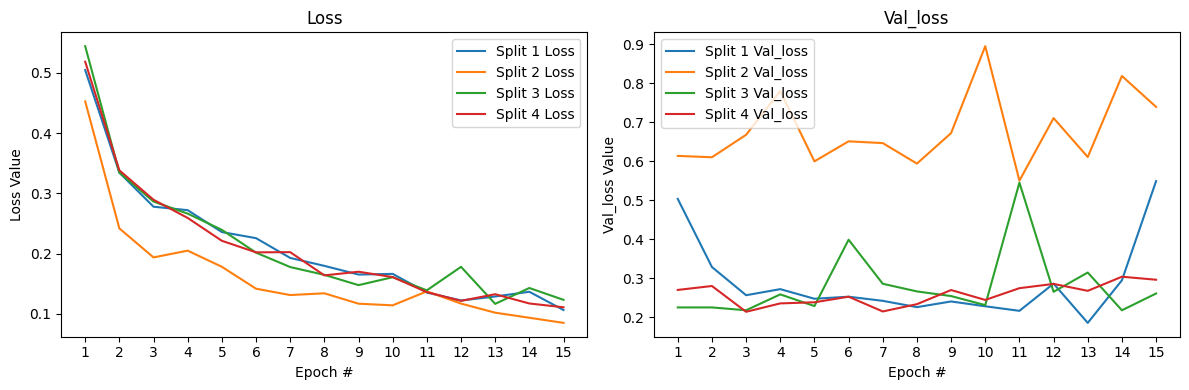

In [24]:
plot_metrics(all_histories, ["loss" , "val_loss"])

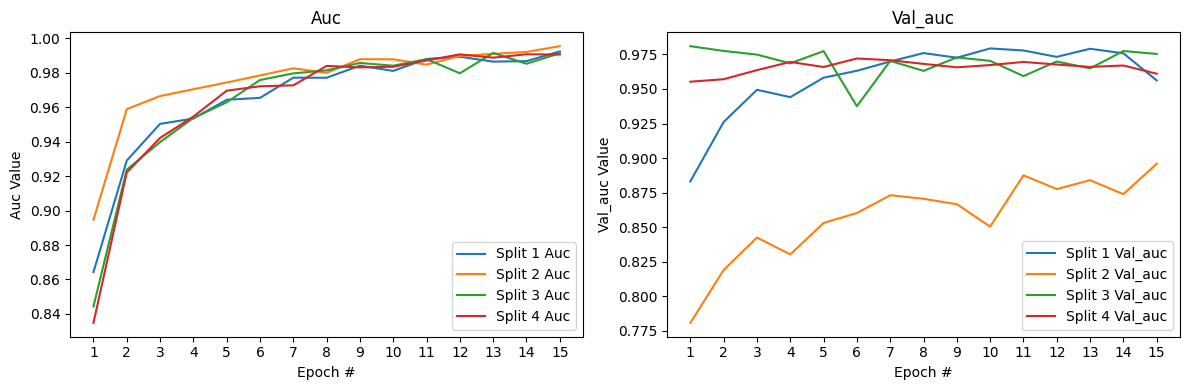

In [25]:
plot_metrics(all_histories, ["auc" , "val_auc"])

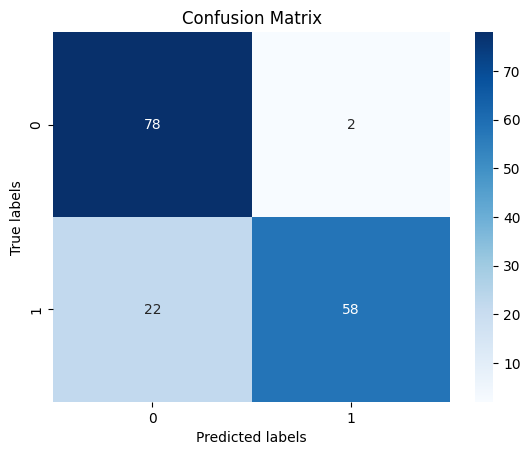

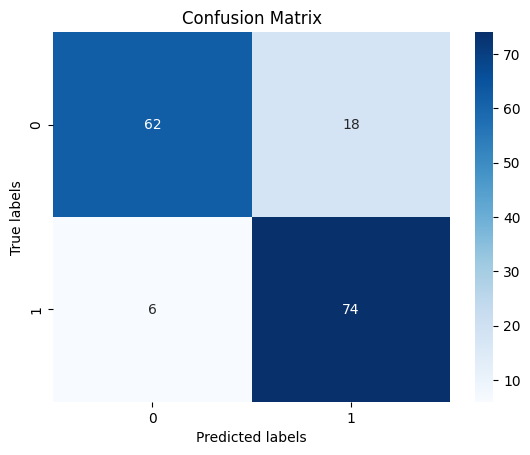

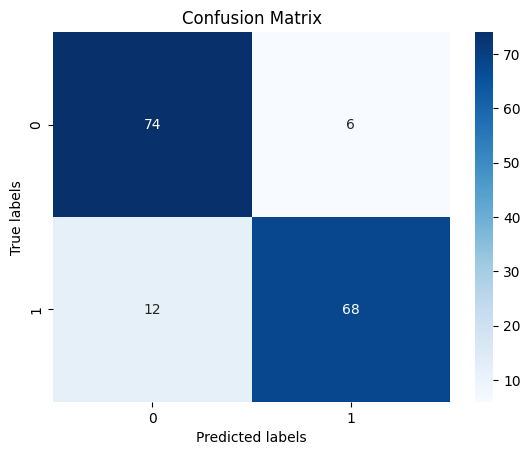

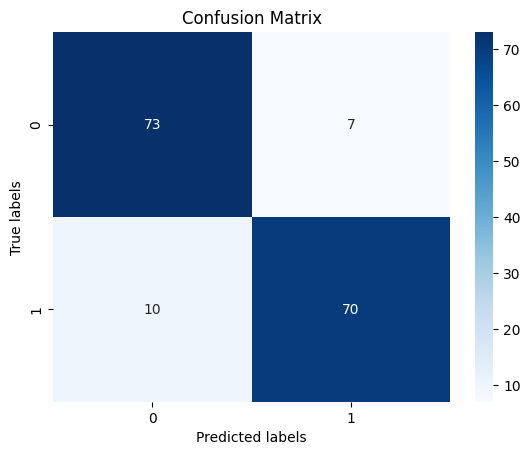

In [28]:
for i in range(len(all_histories)):
    plot_confusion_matrix(all_y_true[i], all_y_pred_binary[i] , [0 , 1])

In [29]:
for i in range(len(all_histories)):
    print(classification_report(all_y_true[i], all_y_pred_binary[i]))

              precision    recall  f1-score   support

           0       0.78      0.97      0.87        80
           1       0.97      0.72      0.83        80

    accuracy                           0.85       160
   macro avg       0.87      0.85      0.85       160
weighted avg       0.87      0.85      0.85       160

              precision    recall  f1-score   support

           0       0.91      0.78      0.84        80
           1       0.80      0.93      0.86        80

    accuracy                           0.85       160
   macro avg       0.86      0.85      0.85       160
weighted avg       0.86      0.85      0.85       160

              precision    recall  f1-score   support

           0       0.86      0.93      0.89        80
           1       0.92      0.85      0.88        80

    accuracy                           0.89       160
   macro avg       0.89      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160

              preci

## Train with HQ Data

In [14]:
num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Epochs = 15
batch_size = 4
epoch_list = list(range(1, Epochs + 1))
all_histories = []
result_train = []
result_test = []
all_y_true = []
all_y_pred_binary = []

#these two variables are used for kfold on persons. 
persons = np.arange(64)
labels = np.concatenate((np.ones(32), np.zeros(32)))


for fold_index, (train_index_p, test_index_p) in enumerate(kf.split(persons , labels)):
    
    K.clear_session()
    gc.collect()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_path = f"vgg_freeze_2_fold_high_54_{fold_index}.h5"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    model = create_model((224 , 224 , 3) , 54) 
    
    train_generator = MyDataGenerator(shuffled_low_real, train_index_p , batch_size)
    val_generator = MyDataGenerator(shuffled_low_real, test_index_p, batch_size )

    history = model.fit(train_generator, epochs=Epochs,validation_data=val_generator , callbacks = [checkpoint])

    all_histories.append(history.history)
    
    
    train_results = model.evaluate(train_generator)
    print("Metrics on train:")
    print(train_results)
    result_train.append(train_results)
        
    test_results = model.evaluate(val_generator)
    print("Metrics on test:")
    print(test_results)
    result_test.append(test_results)
    
    
    y_true =  val_generator.get_true_labels()
    y_pred = model.predict(val_generator)
    y_pred_binary = (y_pred > 0.5).astype(int) 
    all_y_pred_binary.append(y_pred_binary)
    all_y_true.append(y_true)

553467096/553467096 [==============================] - 13s 0us/step
Epoch 1/15
120/120 [==============================] - ETA: 0s - loss: 0.5883 - accuracy: 0.6812 - precision: 0.6629 - recall: 0.7375 - auc: 0.7625
Epoch 1: val_accuracy improved from -inf to 0.69375, saving model to vgg_freeze_2_fold_high_54_0.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 312s 2s/step - loss: 0.5883 - accuracy: 0.6812 - precision: 0.6629 - recall: 0.7375 - auc: 0.7625 - val_loss: 0.5943 - val_accuracy: 0.6938 - val_precision: 0.7460 - val_recall: 0.5875 - val_auc: 0.8098
Epoch 2/15
120/120 [==============================] - ETA: 0s - loss: 0.4478 - accuracy: 0.8021 - precision: 0.8281 - recall: 0.7625 - auc: 0.8718
Epoch 2: val_accuracy improved from 0.69375 to 0.73750, saving model to vgg_freeze_2_fold_high_54_0.h5
120/120 [==============================] - 160s 1s/step - loss: 0.4478 - accuracy: 0.8021 - precision: 0.8281 - recall: 0.7625 - auc: 0.8718 - val_loss: 0.5923 - val_accuracy: 0.7375 - val_precision: 0.6792 - val_recall: 0.9000 - val_auc: 0.8215
Epoch 3/15
120/120 [==============================] - ETA: 0s - loss: 0.4018 - accuracy: 0.8333 - precision: 0.8419 - recall: 0.8208 - auc: 0.8992
Epoch 3: val_accuracy improved from 0.73750 to 0.75000, saving model to vgg_freeze_2_fold_high_54_0.h5
120/120 

## Related Plots and Classification report

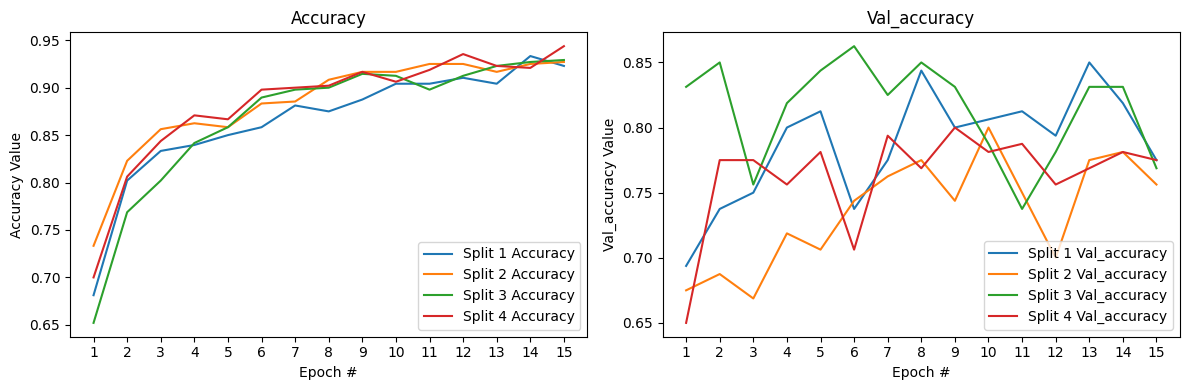

In [15]:
plot_metrics(all_histories, ["accuracy" , "val_accuracy"])

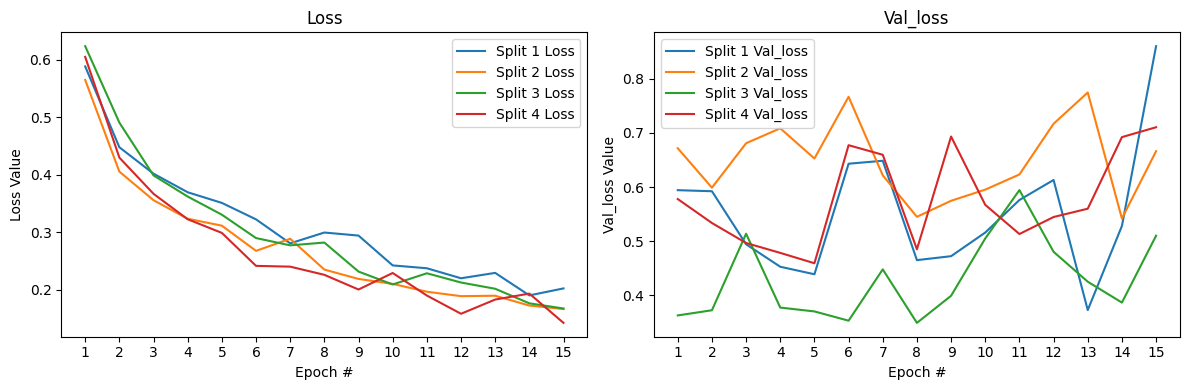

In [16]:
plot_metrics(all_histories, ["loss" , "val_loss"])

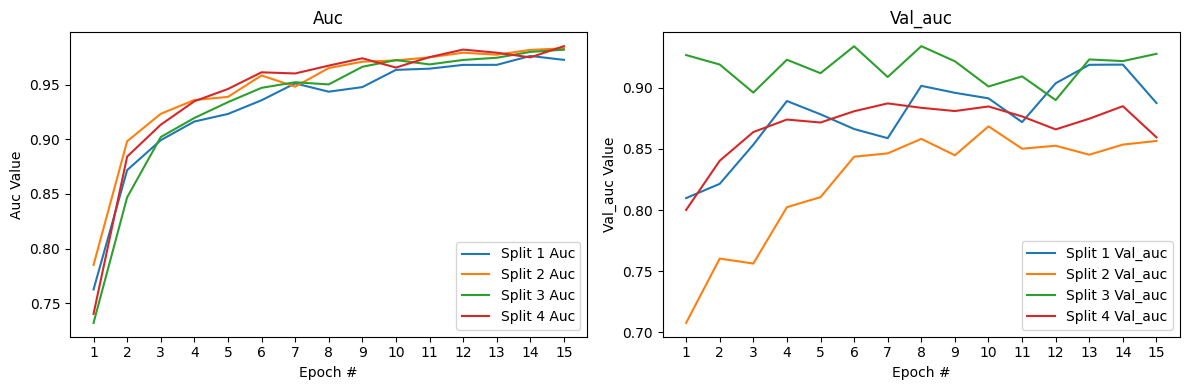

In [17]:
plot_metrics(all_histories, ["auc" , "val_auc"])

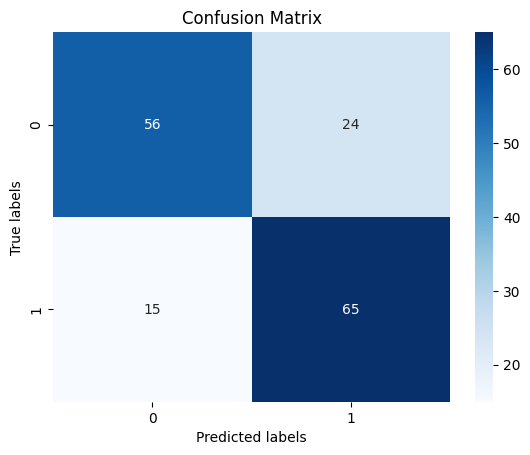

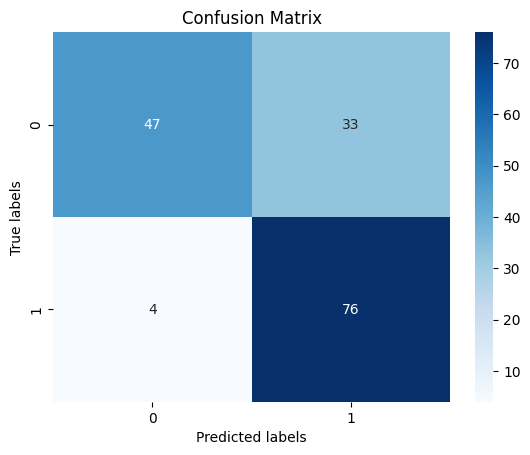

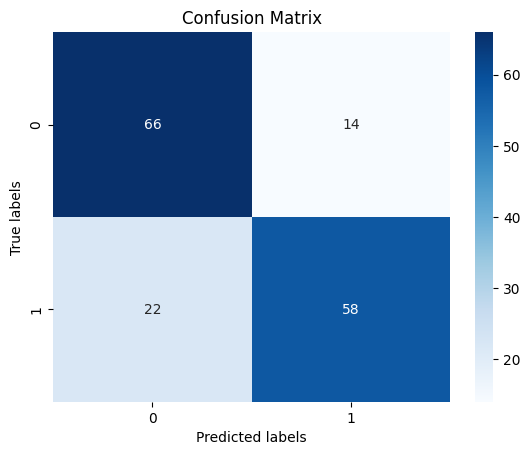

In [24]:
for i in range(len(all_histories)):
    plot_confusion_matrix(all_y_true[i], all_y_pred_binary[i] , [0 , 1])

In [23]:
for i in range(len(all_histories)):
    print(classification_report(all_y_true[i], all_y_pred_binary[i]))

              precision    recall  f1-score   support

           0       0.70      0.95      0.81        80
           1       0.92      0.60      0.73        80

    accuracy                           0.78       160
   macro avg       0.81      0.77      0.77       160
weighted avg       0.81      0.78      0.77       160

              precision    recall  f1-score   support

           0       0.79      0.70      0.74        80
           1       0.73      0.81      0.77        80

    accuracy                           0.76       160
   macro avg       0.76      0.76      0.76       160
weighted avg       0.76      0.76      0.76       160

              precision    recall  f1-score   support

           0       0.92      0.59      0.72        80
           1       0.70      0.95      0.80        80

    accuracy                           0.77       160
   macro avg       0.81      0.77      0.76       160
weighted avg       0.81      0.77      0.76       160

              preci

# VGG16 Unfreeze Last Layer

In [9]:
def create_model(input_shape_frame , frames_per_video):
        
    max_frame = frames_per_video
    input_layer = Input(shape=(max_frame,) + input_shape_frame)
    
    
    vgg = VGG16(weights='imagenet', include_top=True, input_shape=input_shape_frame)
    for layer in vgg.layers[:-1]:
        layer.trainable = False 
    
    time_distributed_vgg = TimeDistributed(vgg)(input_layer)
    #-----------------
    lstm_layer_1 = LSTM(256, return_sequences = True)(time_distributed_vgg)
    lstm_layer_2  = LSTM(256)(lstm_layer_1)
    #-----------------

    output_layer = Dense(1, activation='sigmoid')(lstm_layer_2)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy' ,Precision() , Recall() , AUC()])
    
    return model 

## Train with LQ Data

In [10]:
num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Epochs = 10
batch_size = 4
epoch_list = list(range(1, Epochs + 1))
all_histories = []
result_train = []
result_test = []
all_y_true = []
all_y_pred_binary = []

#these two variables are used for kfold on persons. 
persons = np.arange(64)
labels = np.concatenate((np.ones(32), np.zeros(32)))


for fold_index, (train_index_p, test_index_p) in enumerate(kf.split(persons , labels)):
    
    K.clear_session()
    gc.collect()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_path = f"vgg_freeze_2_fold_high_54_{fold_index}.h5"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    model = create_model((224 , 224 , 3) , 54) 
    
    train_generator = MyDataGenerator(shuffled_low_real, train_index_p , batch_size)
    val_generator = MyDataGenerator(shuffled_low_real, test_index_p, batch_size )

    history = model.fit(train_generator, epochs=Epochs,validation_data=val_generator , callbacks = [checkpoint])

    all_histories.append(history.history)
    
    
    train_results = model.evaluate(train_generator)
    print("Metrics on train:")
    print(train_results)
    result_train.append(train_results)
        
    test_results = model.evaluate(val_generator)
    print("Metrics on test:")
    print(test_results)
    result_test.append(test_results)
    
    
    y_true =  val_generator.get_true_labels()
    y_pred = model.predict(val_generator)
    y_pred_binary = (y_pred > 0.5).astype(int) 
    all_y_pred_binary.append(y_pred_binary)
    all_y_true.append(y_true)

553467096/553467096 [==============================] - 2s 0us/step
Epoch 1/10
120/120 [==============================] - ETA: 0s - loss: 0.4273 - accuracy: 0.8313 - precision: 0.8597 - recall: 0.7917 - auc: 0.9051
Epoch 1: val_accuracy improved from -inf to 0.91875, saving model to vgg_freeze_2_fold_high_54_0.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 433s 3s/step - loss: 0.4273 - accuracy: 0.8313 - precision: 0.8597 - recall: 0.7917 - auc: 0.9051 - val_loss: 0.2311 - val_accuracy: 0.9187 - val_precision: 0.9855 - val_recall: 0.8500 - val_auc: 0.9742
Epoch 2/10
120/120 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.9563 - precision: 0.9469 - recall: 0.9667 - auc: 0.9831
Epoch 2: val_accuracy improved from 0.91875 to 0.93750, saving model to vgg_freeze_2_fold_high_54_0.h5
120/120 [==============================] - 175s 1s/step - loss: 0.1387 - accuracy: 0.9563 - precision: 0.9469 - recall: 0.9667 - auc: 0.9831 - val_loss: 0.1917 - val_accuracy: 0.9375 - val_precision: 0.9487 - val_recall: 0.9250 - val_auc: 0.9855
Epoch 3/10
120/120 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9688 - precision: 0.9668 - recall: 0.9708 - auc: 0.9950
Epoch 3: val_accuracy did not improve from 0.93750
120/120 [==============================] - 169s 1s/step - lo

## Related plots and Classification Report

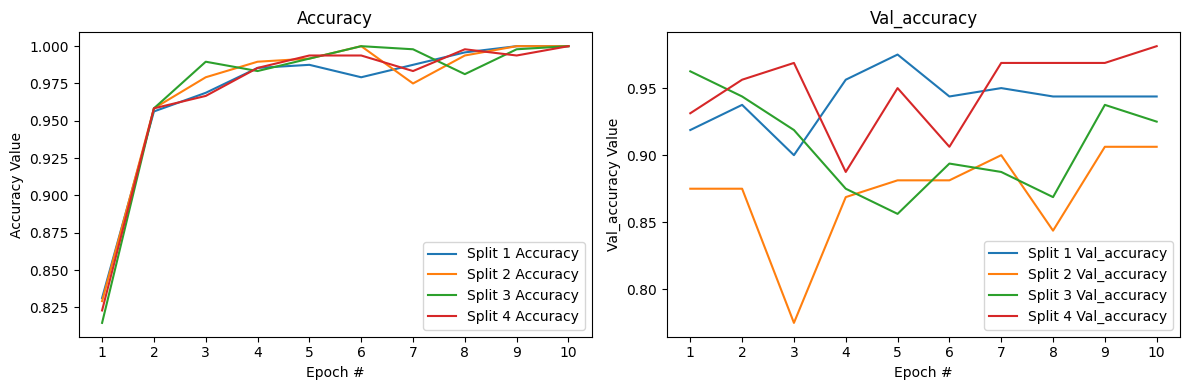

In [12]:
plot_metrics(all_histories, ["accuracy" , "val_accuracy"])

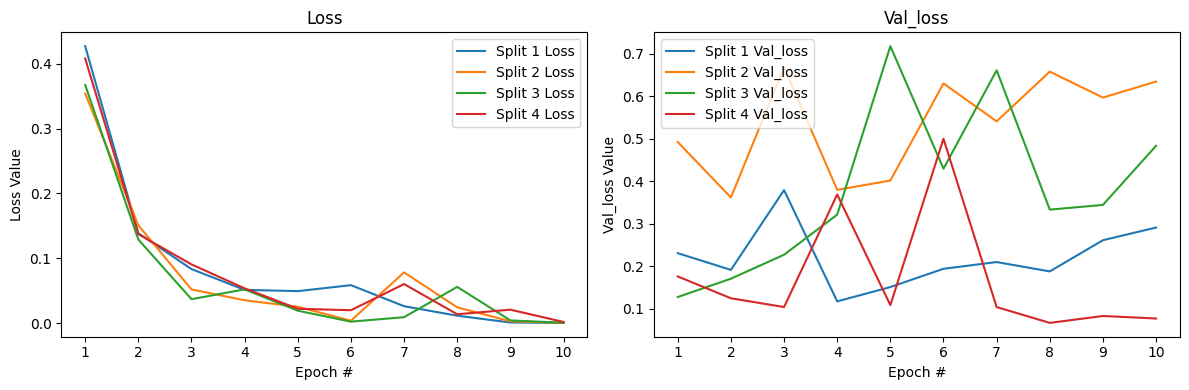

In [13]:
plot_metrics(all_histories, ["loss" , "val_loss"])

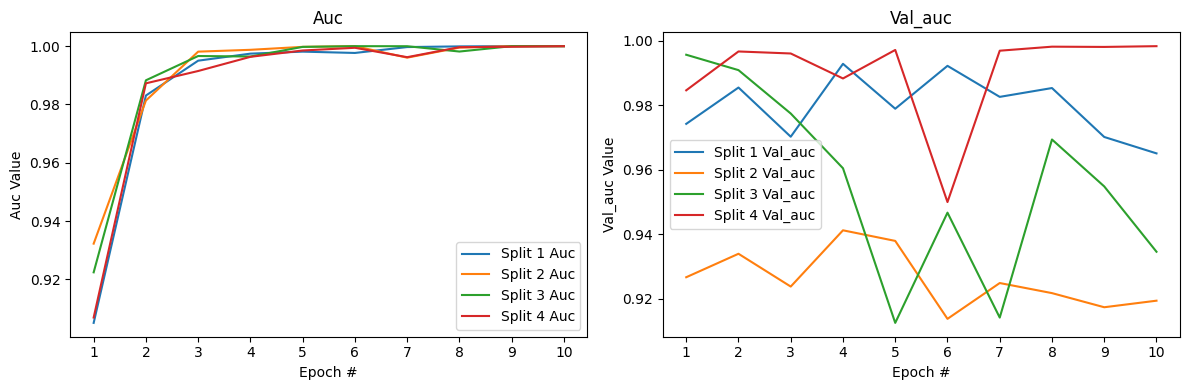

In [14]:
plot_metrics(all_histories, ["auc" , "val_auc"])

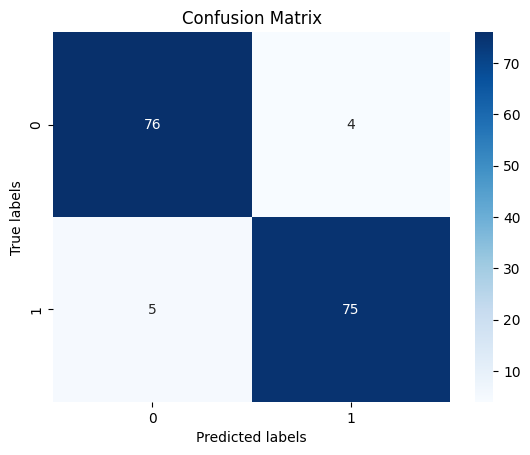

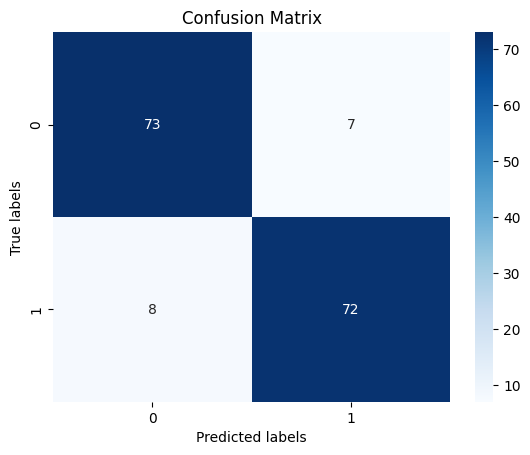

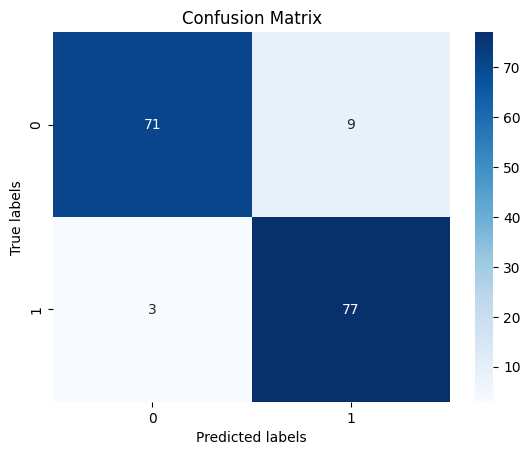

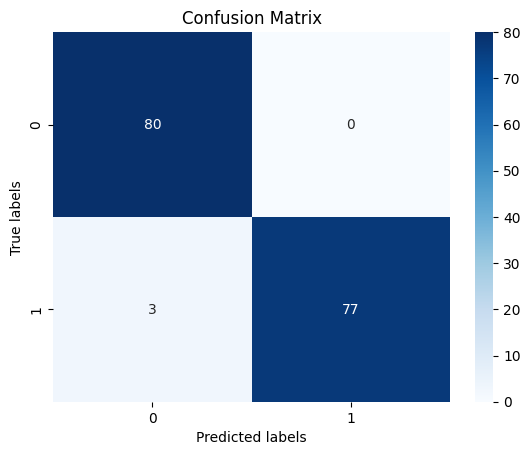

In [17]:
for i in range(len(all_histories)):
    plot_confusion_matrix(all_y_true[i], all_y_pred_binary[i] , [0 , 1])

In [18]:
for i in range(len(all_histories)):
    print(classification_report(all_y_true[i], all_y_pred_binary[i]))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94        80
           1       0.95      0.94      0.94        80

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160

              precision    recall  f1-score   support

           0       0.90      0.91      0.91        80
           1       0.91      0.90      0.91        80

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160

              precision    recall  f1-score   support

           0       0.96      0.89      0.92        80
           1       0.90      0.96      0.93        80

    accuracy                           0.93       160
   macro avg       0.93      0.93      0.92       160
weighted avg       0.93      0.93      0.92       160

              preci

## Train with HQ Data

In [13]:
num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Epochs = 10
batch_size = 4
epoch_list = list(range(1, Epochs + 1))
all_histories = []
result_train = []
result_test = []
all_y_true = []
all_y_pred_binary = []

#these two variables are used for kfold on persons. 
persons = np.arange(64)
labels = np.concatenate((np.ones(32), np.zeros(32)))


for fold_index, (train_index_p, test_index_p) in enumerate(kf.split(persons , labels)):
    
    K.clear_session()
    gc.collect()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_path = f"vgg_unfreeze_2_fold_high_54_{fold_index}.h5"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    model = create_model((224 , 224 , 3) , 54) 
    
    train_generator = MyDataGenerator(shuffled_low_real, train_index_p , batch_size)
    val_generator = MyDataGenerator(shuffled_low_real, test_index_p, batch_size )

    history = model.fit(train_generator, epochs=Epochs,validation_data=val_generator , callbacks = [checkpoint])

    all_histories.append(history.history)
    
    
    train_results = model.evaluate(train_generator)
    print("Metrics on train:")
    print(train_results)
    result_train.append(train_results)
        
    test_results = model.evaluate(val_generator)
    print("Metrics on test:")
    print(test_results)
    result_test.append(test_results)
    
    
    y_true =  val_generator.get_true_labels()
    y_pred = model.predict(val_generator)
    y_pred_binary = (y_pred > 0.5).astype(int) 
    all_y_pred_binary.append(y_pred_binary)
    all_y_true.append(y_true)

553467096/553467096 [==============================] - 3s 0us/step
Epoch 1/10
120/120 [==============================] - ETA: 0s - loss: 0.5147 - accuracy: 0.7312 - precision: 0.7048 - recall: 0.7958 - auc: 0.8237
Epoch 1: val_accuracy improved from -inf to 0.80625, saving model to vgg_unfreeze_2_fold_high_54_0.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 350s 3s/step - loss: 0.5147 - accuracy: 0.7312 - precision: 0.7048 - recall: 0.7958 - auc: 0.8237 - val_loss: 0.4215 - val_accuracy: 0.8062 - val_precision: 0.9153 - val_recall: 0.6750 - val_auc: 0.9222
Epoch 2/10
120/120 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.9333 - precision: 0.9160 - recall: 0.9542 - auc: 0.9720
Epoch 2: val_accuracy did not improve from 0.80625
120/120 [==============================] - 161s 1s/step - loss: 0.2003 - accuracy: 0.9333 - precision: 0.9160 - recall: 0.9542 - auc: 0.9720 - val_loss: 0.8342 - val_accuracy: 0.7937 - val_precision: 0.7765 - val_recall: 0.8250 - val_auc: 0.8369
Epoch 3/10
120/120 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.9708 - precision: 0.9788 - recall: 0.9625 - auc: 0.9891
Epoch 3: val_accuracy did not improve from 0.80625
120/120 [==============================] - 161s 1s/step - loss: 0.1108 - accuracy: 0.9708 - precision: 0.9788 - 

## Related Plots and Classification Report

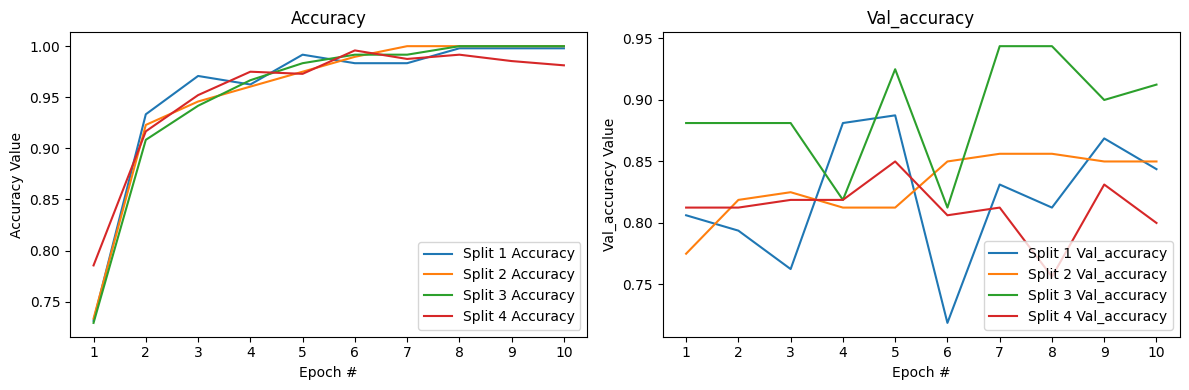

In [14]:
plot_metrics(all_histories, ["accuracy" , "val_accuracy"])

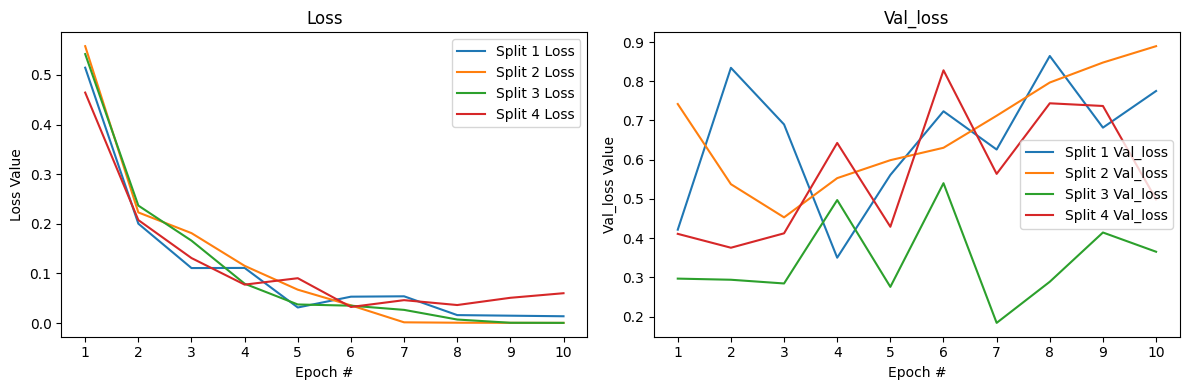

In [15]:
plot_metrics(all_histories, ["loss" , "val_loss"])

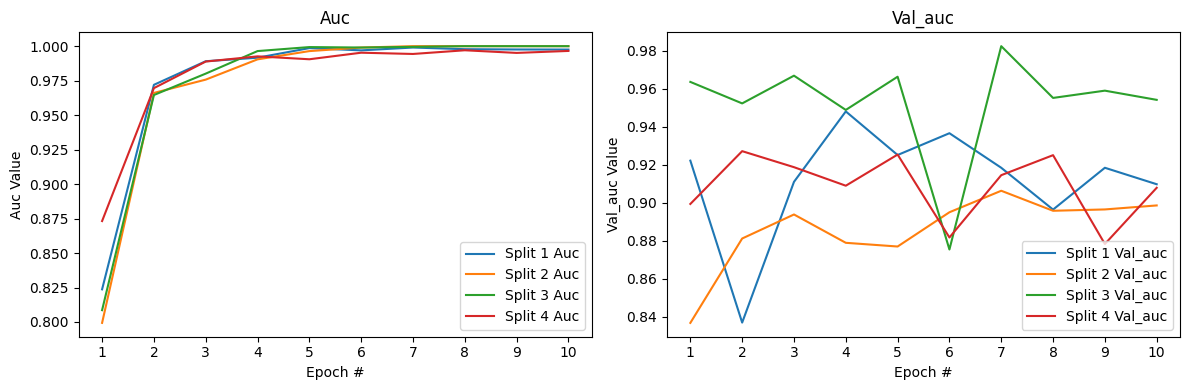

In [16]:
plot_metrics(all_histories, ["auc" , "val_auc"])

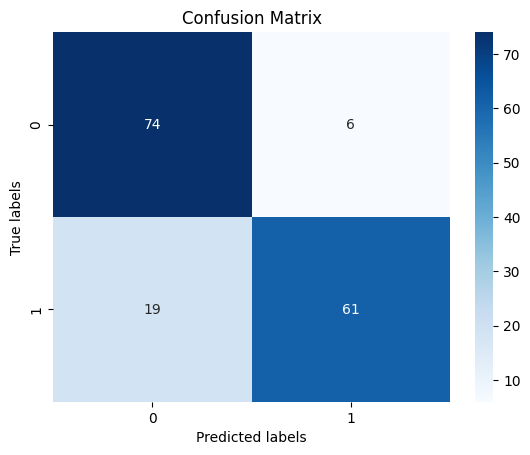

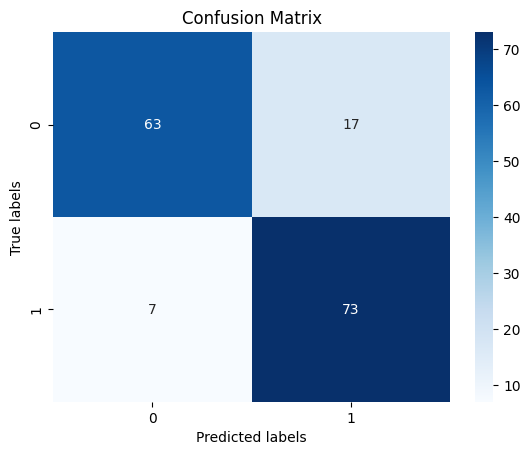

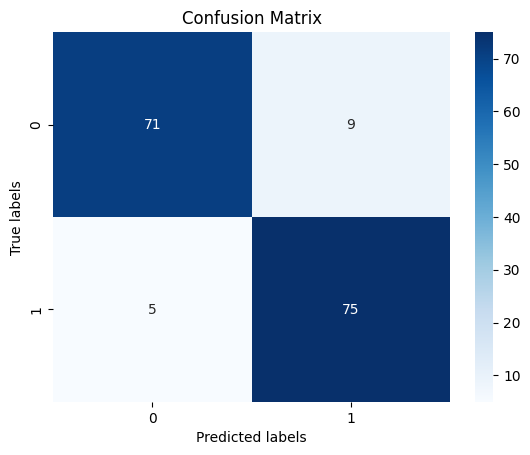

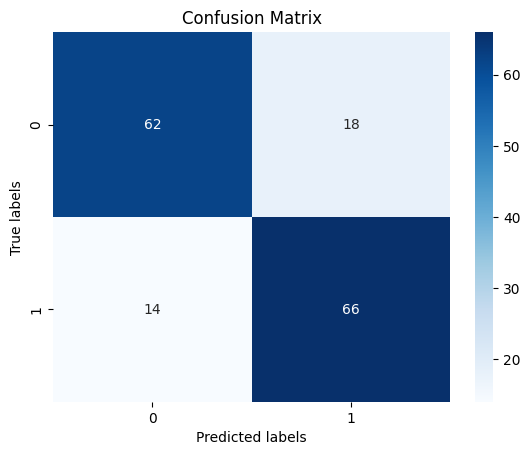

In [19]:
for i in range(len(all_histories)):
    plot_confusion_matrix(all_y_true[i], all_y_pred_binary[i] , [0 , 1])

In [20]:
for i in range(len(all_histories)):
    print(classification_report(all_y_true[i], all_y_pred_binary[i]))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86        80
           1       0.91      0.76      0.83        80

    accuracy                           0.84       160
   macro avg       0.85      0.84      0.84       160
weighted avg       0.85      0.84      0.84       160

              precision    recall  f1-score   support

           0       0.90      0.79      0.84        80
           1       0.81      0.91      0.86        80

    accuracy                           0.85       160
   macro avg       0.86      0.85      0.85       160
weighted avg       0.86      0.85      0.85       160

              precision    recall  f1-score   support

           0       0.93      0.89      0.91        80
           1       0.89      0.94      0.91        80

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160

              preci